## Advection Equation -> Gaussian Profile

Here we solve the advection equation $u_t + a u_x=0$ using as an initial condition a gaussian profile $u(x,t=0)=\exp{[-(x-x_0)^2]}$ with $x_0=5$.

We use a domain $x\in [0,10]$ with periodic boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

In [2]:
#Define the speed a
a = 1.0

#Define the domain
L = 10.0                    #Domain length
nx = 101                    #Number of grid points
dx = L / (nx - 1)           #Grid spacing
x = np.linspace(0, L, nx)   #Grid 

#Define the time step and the final time
cf = 0.5                    #Courant Factor
dt = (cf * dx) / a          #Time step
t_final = 20.0

print('Domain Length = ', L)
print('Grid Points = ', nx)
print('Grid resolution dx = ', dx)
print('Time resolution dt = ', dt)
print('Time of evolution  = ', t_final)
print('Number of iterations = ', t_final/dt)

#Define the initial condition
x0 = 5
u_initial = np.exp(-(x - x0)**2)

#Initialize the solution array
u_current = u_initial.copy()

#We create 2 arrays where we will store the time and the l2norm
l2norm = []
time = []

Domain Length =  10.0
Grid Points =  101
Grid resolution dx =  0.1
Time resolution dt =  0.05
Time of evolution  =  20.0
Number of iterations =  400.0


In [3]:
#methods = ['FTCS', 'Lax-Friedrichs', 'Leapfrog', 'Lax-Wendroff']

methods = ['Leapfrog']

/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_4279/4203887517.py:115: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  current_image = imageio.imread('./Schemes/' + key + '/' + file)
/var/folders/hz/p6990d5s151fqhq0n07rh8sm0000gn/T/ipykernel_4279/4203887517.py:126: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, panels, k+1)


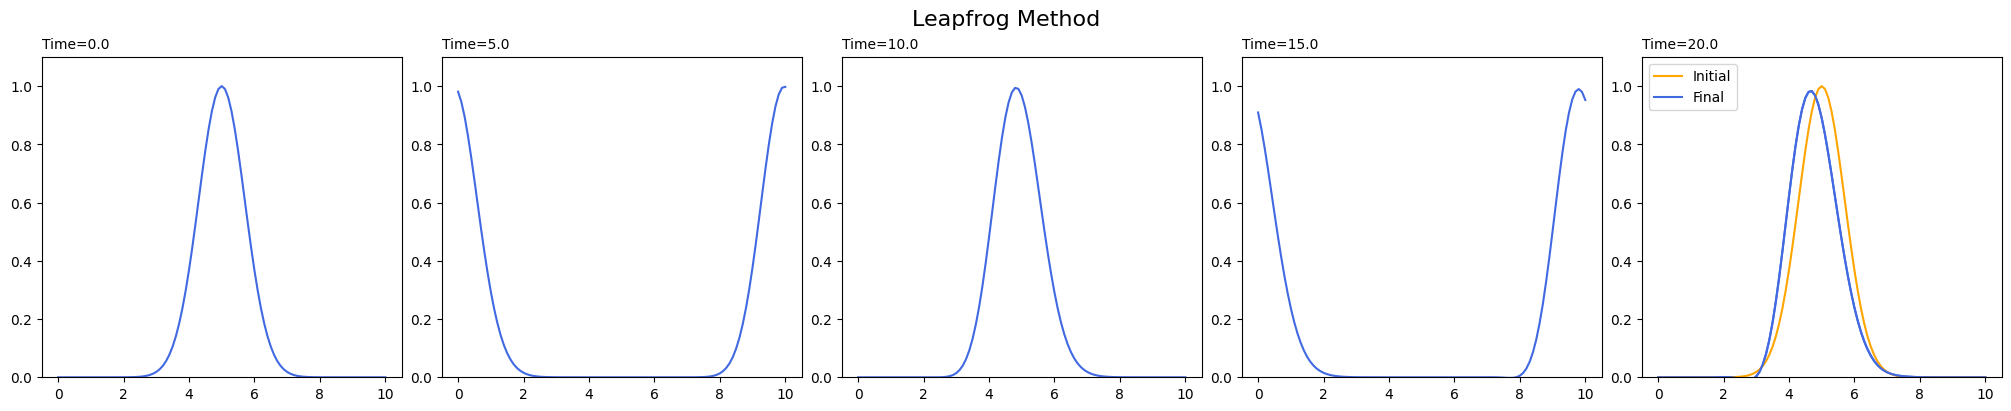

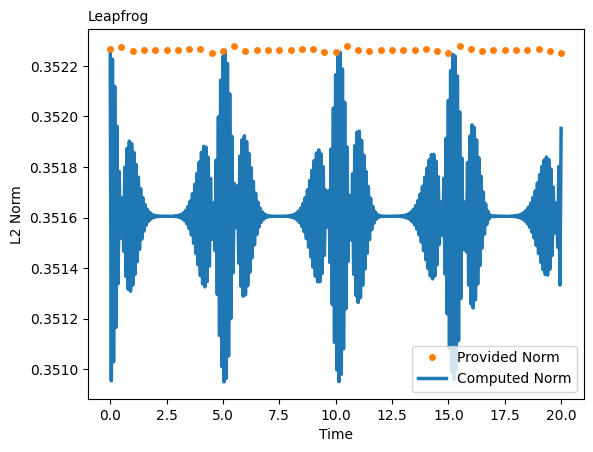

In [4]:
#Create directory where to save images

plotsave = []
timesave = []

#Number of snapshots steps to produce a figure with 5 panels. The first one is the initial state and the last one is the final state, distributed in between with even spacing
step_panels = round(t_final/(4 * dt), 0)

panels = 5

for key in methods:
    #Default path
    os.chdir('/Users/oliverbenjaminrossi/Visual Studio/Università/Numerical-Relativity/Advection/Schemes')

    #New folder
    dir = './' + key

    #Enter new folder
    os.chdir(dir)

    #Reset Step
    l2norm.clear()
    time.clear()

    #Initial Conditions
    u_current = u_initial.copy()
    plotsave.append(u_current)
    l2norm.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
    time.append(0.0)
    timesave.append('Time='+str(round(time[0],2)))

    #Initilize time and iteration counter
    t = 0.0
    i = 0
    c1 = (a * dt) / dx

    #Save the initial conditions
    plt.plot(x, u_current)
    plt.title(key + ' Method Time = ' + str(round(t, 2)))
    plt.ylim(0, 1.1)
    plt.savefig('fig_' + str(i).zfill(5)+'.png', dpi=200)
    plt.close()

    #Solve the advection equation
    while t < t_final:

            # Note: np.roll(u_current, -1) is equivalent to u(j+1) and
            #       np.roll(u_current,  1) is equivalent to u(j-1)
            #       using np.roll is equivalent to use periodic boundary conditions

        if key == 'FTCS':
            #Compute solution with FTCS method
            u_next = u_current - 0.5 * c1 * (np.roll(u_current, -1) - np.roll(u_current, 1))

        elif key == 'Lax-Friedrichs':
            #Compute solution with Lax-Friedrichs method
            u_next = 0.5 * (np.roll(u_current, 1) + np.roll(u_current, -1)) - 0.5 * c1 * (np.roll(u_current, -1) - np.roll(u_current, 1))

        elif key == 'Leapfrog':
            #Compute solution with Leapfrog method
            if t == 0.0: #First step -> Compute first evolution with Lax-Friedrichs (or FTCS, but I chose Lax-Friedrichs)
                u_next = 0.5 * (np.roll(u_current, 1) + np.roll(u_current, -1)) - 0.5 * c1 * (np.roll(u_current, -1) - np.roll(u_current, 1))
                u_previous = u_initial.copy()

            else: #Second step -> We can move forwards with Leapfrog!
                u_next = u_previous - c1 * (np.roll(u_current, -1) - np.roll(u_current, 1))
                u_previous = u_current.copy()

        elif key == 'Lax-Wendroff':
            #Compute solution with Lax-Wendroff method
            u_next = u_current - 0.5 * c1 * (np.roll(u_current, -1) - np.roll(u_current, 1)) + 0.5 * (c1 ** 2) * (np.roll(u_current, -1) -2 * u_current + np.roll(u_current, 1))

        #Update the solution
        u_current = u_next.copy()
        
        #Advance the time 
        t += dt
        i += 1
        
        #Compute the l2 norm and add the time to the time vector
        #l2norm.append(np.sqrt(np.sum(u_current**2)/len(u_current)))
        l2norm.append(np.sqrt(np.sum((u_current**2)/len(u_current))))
        time.append(t)

        #Plot the current result and save in an image every 5 iterations
        if (i%5 == 0):
            plt.plot(x, u_current)
            current_time = 'Time='+str(round(t,2))
            plt.title(current_time)
            plt.ylim(0, 1.1)
            plt.savefig('fig_' + str(i).zfill(5)+'.png', dpi=200)
            plt.close()

        if(i%step_panels == 0):
            plotsave.append(u_current)
            current_time = 'Time='+str(round(t,2))
            timesave.append(current_time)


    #Saving last position in case of non integer frame division
    plotsave[-1] = u_current
    timesave[-1] = 'Time='+str(round(time[-1],2))

    #Movie Creation
    #Get the list of image files in the current directory
    files = os.listdir('./')

    #Sort the files in alphanumeric order
    files = sorted(files)

    os.chdir('/Users/oliverbenjaminrossi/Visual Studio/Università/Numerical-Relativity/Advection')

    with imageio.get_writer('./Movies/' + key + '.mp4', mode='I', fps=10) as writer:
        for file in files:
            current_image = imageio.imread('./Schemes/' + key + '/' + file)
            writer.append_data(current_image)

    files = []

    #Evolution plots
    os.chdir('/Users/oliverbenjaminrossi/Visual Studio/Università/Numerical-Relativity/Advection')

    fig, ax = plt.subplots(figsize=(20, 4), layout='constrained')
    fig.suptitle(key + ' Method', fontsize=16)
    for k in range(0, panels):
        plt.subplot(1, panels, k+1)
        plt.plot(x, plotsave[k], c='royalblue')

        if k == (panels-1):     #Visualizing initial vs last
            plt.plot(x, u_initial, label='Initial', c='orange')
            plt.plot(x, plotsave[k], label='Final', c='royalblue')
        
        plt.ylim(0, 1.1)
        plt.title(timesave[k], fontsize=10, loc='left')
    
    plt.legend(loc='upper left', fontsize=10)
    plt.savefig(key + 'evolutionplot.png', dpi=400)
    plt.show()

    plotsave.clear()
    timesave.clear()

    #L2 Norm Comparison with provided data
    l2_saved = np.genfromtxt('l2norm_' + key + '.dat', comments='#')

    plt.plot(l2_saved[:, 0], l2_saved[:, 1], '.', markersize=8, label='Provided Norm', c='C1', zorder=2)
    plt.plot(time, l2norm, label='Computed Norm', linewidth=2.5, c='C0', zorder=1)
    plt.title(key, loc='left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('L2 Norm')
    plt.legend()
    plt.savefig('norm' + key + '.png', dpi=400)
    plt.show()

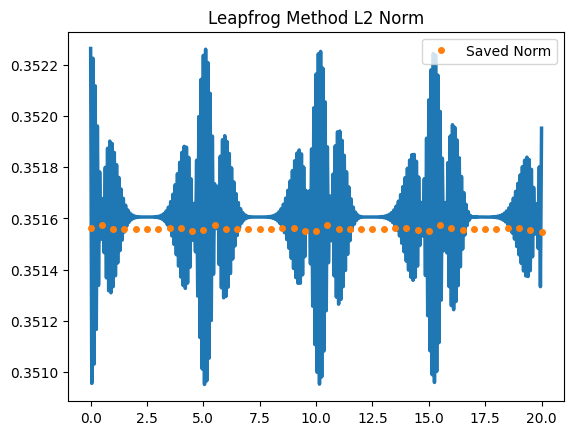

0.35226300000000005
6.2625483786662606e-06


In [14]:
#L2 Norm Comparison with stored data
l2_saved = np.genfromtxt('l2norm_Leapfrog.dat', comments='#')

plt.plot(time, l2norm, linewidth=2.5, zorder=1)
plt.plot(l2_saved[:, 0], (l2_saved[:, 1])/1.002, '.', markersize=8, label='Saved Norm', c='C1', zorder=2)
plt.title(key + ' Method L2 Norm')
plt.legend()
plt.savefig('./L2_Norm/L2_Norm_' + key + '.png', dpi=200)

plt.show()

print(np.mean(l2_saved[:, 1]))
print(np.std(l2_saved[:, 1]))

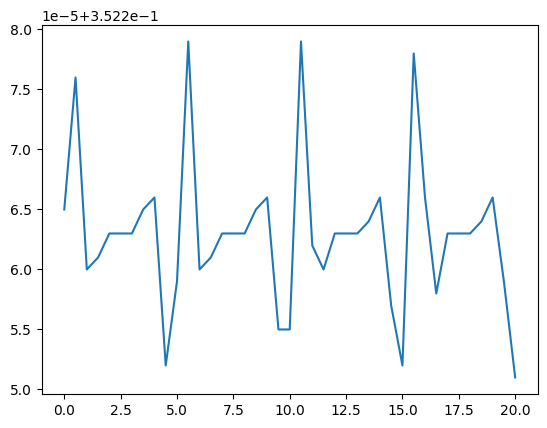

In [7]:
plt.plot(l2_saved[:, 0], l2_saved[:, 1])